In [37]:
import numpy as np
import copy

import time
from PIL import Image
from IPython.display import Image as disimage

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [45]:
content_img = Image.open('images/base_img.jpg')
style_image_paths = ['images/base.jpg', 'base2.jpg']

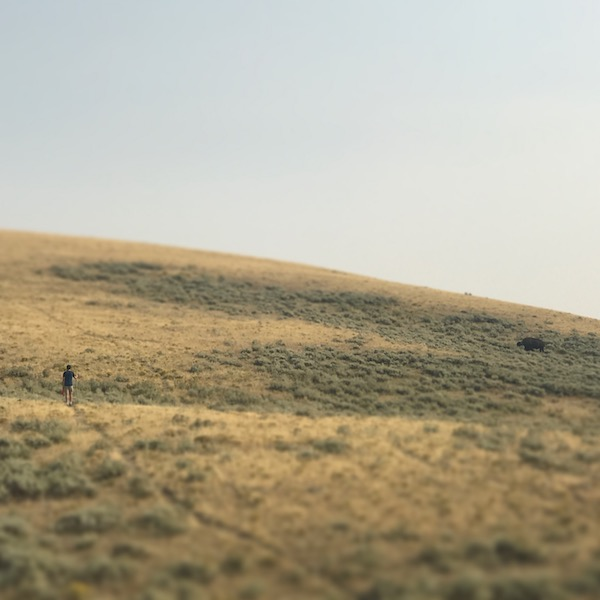

In [46]:
disimage("images/base_img.jpg")

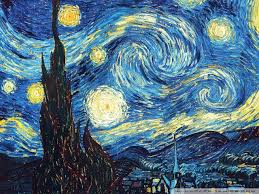

In [47]:
disimage("images/source.jpg")

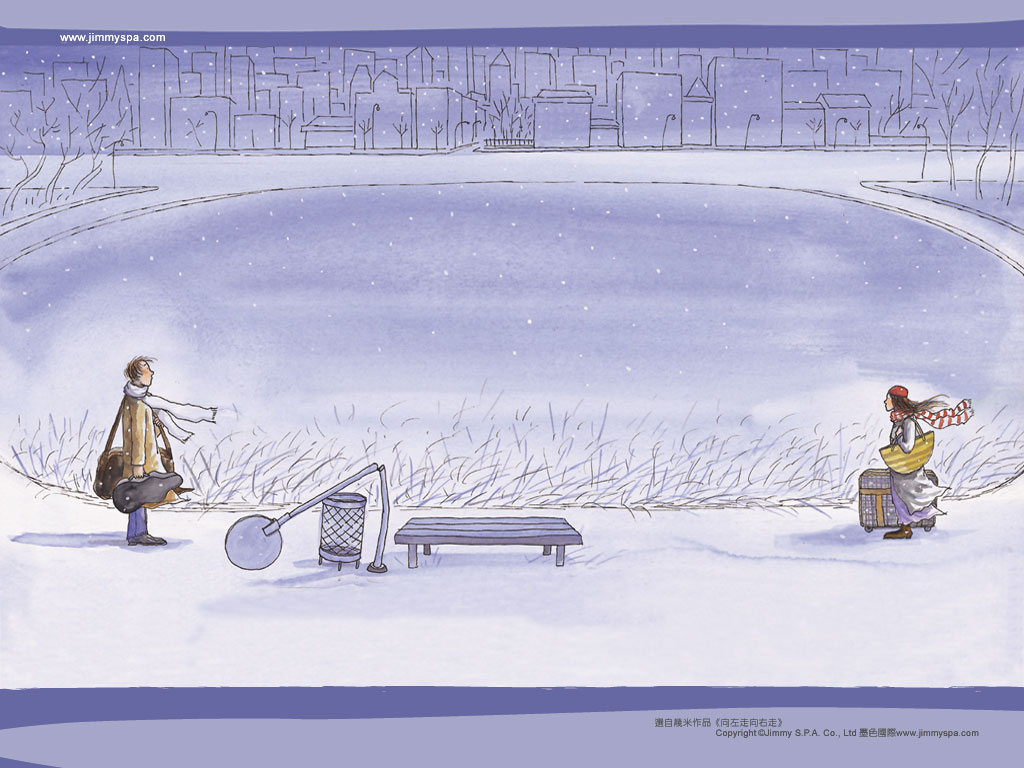

In [53]:
disimage("images/source2.jpg")

In [ ]:
height = 512
width = 512

content_img = Image.open('images/base_img.jpg')
content_img = content_img.resize((height, width))
content_arr = np.asarray(content_img, dtype='float32')
content_arr = np.expand_dims(content_arr, axis=0)
content_arr[:, :, :, 0] -= 103.939
content_arr[:, :, :, 1] -= 116.779
content_arr[:, :, :, 2] -= 123.68
# Convert from RGB to BGR
content_arr = content_arr[:, :, :, ::-1]
content_img = backend.variable(content_arr)

style_image_paths = ['images/source.jpg', 'images/source2.jpg']
style_imgs = []
for style_img_path in style_image_paths:
    style_img = Image.open(style_img_path)
    style_img = style_img.resize((height, width))
    style_arr = np.asarray(style_img, dtype='float32')
    style_arr = np.expand_dims(style_arr, axis=0)
    style_arr[:, :, :, 0] -= 103.939
    style_arr[:, :, :, 1] -= 116.779
    style_arr[:, :, :, 2] -= 123.68
    # Convert from RGB to BGR
    style_arr = style_arr[:, :, :, ::-1]
    style_img = backend.variable(style_arr)
    style_imgs.append(style_img)

# Channels as the last dimension, using backend Tensorflow
combination_img = backend.placeholder((1, height, width, 3))

# We now finally have the content image variable, style image variables and combination image placeholder
# that we will concatenate to build a final input tensor to build our computation graph on top of, essentially
# we pass all these inputs to the network as if they are a part of a batch so they are all run parallely and we
# use the features generated to modify our combination image based on the losses

all_imgs = [content_img]
for style_img in style_imgs:
    all_imgs.append(style_img)
all_imgs.append(combination_img)

input_tensor = backend.concatenate(all_imgs, axis=0)

model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

layers = dict([(layer.name, layer.output) for layer in model.layers])

content_weight = 0.025
style_weight = 5.0
tv_weight = 1.0

loss = backend.variable(0.)

# --------------------------------------------------

def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

# Add content loss to this layer
layer_features = layers['block2_conv2']
content_features = layer_features[0, :, :, :]
combination_features = layer_features[1 + len(style_imgs), :, :, :]

loss += content_weight * content_loss(content_features, combination_features)

# --------------------------------------------------

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    for style_img_idx in range(len(style_imgs)):
        style_features = layer_features[1 + style_img_idx, :, :, :]
        combination_features = layer_features[1 + len(style_imgs), :, :, :]
        style_l = style_loss(style_features, combination_features)
        loss += (style_weight / (len(feature_layers)*len(style_imgs))) * style_l

# ---------------------------------------------------

# Total variation loss to ensure the image is smooth and continuous throughout

def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += tv_weight * total_variation_loss(combination_img)

# ----------------------------------------------------

# Since all of these variables are nodes in our computational graph, we can directly
# calculate the gradients
grads = backend.gradients(loss, combination_img)

outputs = [loss]
outputs += grads
# Create the function from input combination_img to the loss and gradients
f_outputs = backend.function([combination_img], outputs)

# We finally have the gradients and losses at the combination_img computed as variables
# and we can use any standard optimization function to optimize combination_img

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.0

iters = 10

for i in range(iters):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

    x1 = copy.deepcopy(x)
    x1 = x1.reshape((height, width, 3))
    # Convert back from BGR to RGB to display the image
    x1 = x1[:, :, ::-1]
    x1[:, :, 0] += 103.939
    x1[:, :, 1] += 116.779
    x1[:, :, 2] += 123.68
    x1 = np.clip(x1, 0, 255).astype('uint8')
    img_final = Image.fromarray(x1)
    img_final.save('result' + str(i) + '.bmp')

58892288/58889256 [==============================] - 6s     
Start of iteration 0
